In [2]:
%%capture
import warnings
import math
import pickle
import pandas as pd
import numpy as np
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook, show
import matplotlib.pyplot as plt
from datetime import date, datetime
from tqdm.notebook import tqdm
import re
warnings.filterwarnings('ignore')
try:
    %load_ext autotime
    %load_ext jupyterlab_notify
except:
    !pip3 install ipython-autotime
    %load_ext autotime


time: 1.06 s (started: 2023-02-09 12:30:44 -05:00)


In [74]:
df = pd.read_csv('modern_matches.csv')
df = df[['home_ml', 'away_ml', 'over', 'under',
        'spread', 'home_spread', 'home_ps_odds', 'away_spread', 'away_ps_odds', 
        'movl', 'h_win', 'playoff_game', 'past_3_home_favorite_wins', 
         'past_3_away_favorite_wins', 'season']]
df['vig'] = 1/df['home_ml'] + 1/df['away_ml'] 
df=df.dropna(subset=['home_ml','away_ml'])
df['past_3_home_favorite_wins'].describe()


count    11469.000000
mean         0.336153
std          0.320110
min          0.000000
25%          0.000000
50%          0.333333
75%          0.666667
max          1.000000
Name: past_3_home_favorite_wins, dtype: float64

time: 405 ms (started: 2023-02-09 17:48:59 -05:00)


In [4]:
df.head()

,home_ml,away_ml,over,under,spread,home_spread,home_ps_odds,away_spread,away_ps_odds,movl,h_win,playoff_game,vig
0,1.099266,8.100000,1.928189,1.919112,189.000000,-12.250000,1.918323,12.250000,1.930435,10.0,1,0.0,1.033155
1,1.456783,2.830000,1.919388,1.913339,188.583333,-5.000000,1.914808,5.000000,1.917832,12.0,1,0.0,1.039801
2,5.400000,1.171482,1.913339,1.919388,202.083333,9.666667,1.931457,-9.666667,1.902503,13.0,1,0.0,1.038805
3,1.103647,7.890000,1.898696,1.950524,206.333333,-12.000000,1.902854,12.000000,1.952132,31.0,1,0.0,1.032829
4,1.058775,11.460000,1.926327,1.921602,200.583333,-13.000000,1.917696,13.000000,1.929807,13.0,1,0.0,1.031748


time: 10.8 ms (started: 2023-02-09 00:29:57 -05:00)


## Underdog Win Percentage

In [136]:
len(df)

11516

time: 1.26 ms (started: 2023-02-08 02:12:46 -05:00)


In [4]:
df=df.dropna(subset=['home_ml','away_ml'])
len(df)

11513

time: 4.46 ms (started: 2023-02-09 12:30:48 -05:00)


In [5]:
df.isna().any()

home_ml         False
away_ml         False
over            False
under           False
spread          False
home_spread     False
home_ps_odds    False
away_spread     False
away_ps_odds    False
movl            False
h_win           False
playoff_game    False
vig             False
dtype: bool

time: 5.29 ms (started: 2023-02-09 12:30:48 -05:00)


### Percentage of underdogs from 2013 to 2022

In [59]:
n_matches = len(df)
underdog_winners = df[ ((df.h_win == 1) & (df.home_ml > df.away_ml)) |
                          ((df.h_win == 0) & (df.away_ml > df.home_ml)) ]

print('total matches: ', n_matches)
print('underdogs that won: ', len(underdog_winners))
print('underdog win %: ', len(underdog_winners)/n_matches)

total matches:  11516
underdogs that won:  3683
underdog win %:  0.3198159083014936
time: 2.39 ms (started: 2023-02-07 19:25:28 -05:00)


In [23]:
massive_underdogs = df[ (df.home_ml > 3) | (df.away_ml > 3) ]
print('number of underdogs whose odds > 3 (p(win) = 1/3): ',
     len(massive_underdogs))

massive_underdog_winners = df[ (((df.h_win == 1) & (df.home_ml > df.away_ml)) |
                          ((df.h_win == 0) & (df.away_ml > df.home_ml))) &
                              ((df.home_ml > 3) | (df.away_ml > 3))]
print('number of underdogs whose odds > 3 (p(win) = 1/3): ',
     len(massive_underdog_winners))

print('win ratio',len(massive_underdog_winners)/len(massive_underdogs))



number of underdogs whose odds > 3 (p(win) = 1/3):  5514
number of underdogs whose odds > 3 (p(win) = 1/3):  1213
win ratio 0.2199854914762423
time: 3.89 ms (started: 2023-02-07 16:08:25 -05:00)


In [47]:
odds = np.linspace(2,4,5)
interval = 0.5
for o in odds:
    massive_underdogs = df[ ((df.home_ml > o) & (df.home_ml < (o+interval))) | 
                           ((df.away_ml > o) & (df.away_ml < (o+interval))) ]
    print(f'number of underdogs with p(win) = {1/o}: {len(massive_underdogs)}')
    massive_underdog_winners = df[ (((df.h_win == 1) & (df.home_ml > df.away_ml)) |
                              ((df.h_win == 0) & (df.away_ml > df.home_ml))) &
                                  (((df.home_ml > o) & (df.home_ml < (o+interval))) | 
                                   ((df.away_ml > o) & (df.away_ml < (o+interval))))]
    print(f'number of underdog winners with p(win) = {1/o}: {len(massive_underdog_winners)}')
    print(f'win ratio {len(massive_underdog_winners)/len(massive_underdogs)}')

number of underdogs with p(win) = 0.5: 3201
number of underdog winners with p(win) = 0.5: 1383
win ratio 0.4320524835988753
number of underdogs with p(win) = 0.4: 2303
number of underdog winners with p(win) = 0.4: 825
win ratio 0.35822839774207554
number of underdogs with p(win) = 0.3333333333333333: 1394
number of underdog winners with p(win) = 0.3333333333333333: 406
win ratio 0.29124820659971307
number of underdogs with p(win) = 0.2857142857142857: 994
number of underdog winners with p(win) = 0.2857142857142857: 294
win ratio 0.29577464788732394
number of underdogs with p(win) = 0.25: 651
number of underdog winners with p(win) = 0.25: 138
win ratio 0.2119815668202765
time: 13.4 ms (started: 2023-02-07 16:51:10 -05:00)


In [48]:
massive_underdog_winners.head()

,home_ml,away_ml,over,under,spread,home_spread,away_spread,movl,h_win
453,1.267079,4.060000,1.913966,1.933818,208.833333,-7.833333,7.833333,-19.0,0
477,1.238188,4.363333,1.930851,1.917049,220.000000,-8.833333,8.833333,-9.0,0
525,1.269202,4.035000,1.924870,1.923521,217.166667,-7.916667,7.916667,-1.0,0
569,1.271648,4.013333,1.919388,1.928490,213.083333,-8.250000,8.250000,-7.0,0
625,1.255423,4.176667,1.921602,1.926327,205.750000,-8.250000,8.250000,-4.0,0


time: 7.29 ms (started: 2023-02-07 16:53:55 -05:00)


In [7]:
# bet on underdogs
def bet_underdog(df):
    balance = 0
    for index, row in df.iterrows():
        # away is underdog, we bet on away
        if row['home_ml'] < row['away_ml']:
            if row['h_win']:
                balance -= 1/(row['away_ml']-1)
                df.at[index, 'bet_won'] = 0
                df.at[index, 'profit'] = 0
            else:
                balance += 1
                df.at[index, 'bet_won'] = 1
                df.at[index, 'profit'] = 1
            df.at[index, 'bet_amount'] = 1/(row['home_ml']+1)
        else:
            if row['h_win']:
                balance += 1
                df.at[index, 'bet_won'] = 1
                df.at[index, 'profit'] = 1
            else:
                balance -= 1/(row['home_ml']-1)
                df.at[index, 'bet_won'] = 0
                df.at[index, 'profit'] = 0
            df.at[index, 'bet_amount'] = 1/(row['away_ml']+1)

        df.at[index, 'balance'] = balance
    return balance
        


time: 947 µs (started: 2023-02-09 12:31:05 -05:00)


In [8]:
# bet on favorites
def bet_favorite(df):
    balance = 0
    for index, row in df.iterrows():
        if row['home_ml'] > row['away_ml']:
            if row['h_win']:
                balance -= 1/(row['away_ml']-1)
                df.at[index, 'bet_won'] = 0
                df.at[index, 'profit'] = 0
            else:
                balance += 1
                df.at[index, 'bet_won'] = 1
                df.at[index, 'profit'] = 1
            df.at[index, 'bet_amount'] = 1/(row['home_ml']+1)
        else:
            if row['h_win']:
                balance += 1
                df.at[index, 'bet_won'] = 1
                df.at[index, 'profit'] = 1
            else:
                balance -= 1/(row['home_ml']-1)
                df.at[index, 'bet_won'] = 0
                df.at[index, 'profit'] = 0
            df.at[index, 'bet_amount'] = 1/(row['away_ml']+1)

        df.at[index, 'balance'] = balance
    return balance

time: 1.03 ms (started: 2023-02-09 12:31:06 -05:00)


In [194]:
def bet_mixed(df):
    balance = 0
    for index, row in df.iterrows():
        underdog = False
        bet_won = 0
        profit = 0.0
        factor = max(1, balance * 0.05)
        factor = 100
        if abs(row['home_ml'] - row['away_ml']) > 0.25:
            # bet underdog
            underdog = True
        
        if (row['home_ml'] > row['away_ml'] and underdog) or \
            (row['home_ml'] < row['away_ml'] and not underdog):
            bet_amount = 1/(row['home_ml']-1)
            if not underdog:
                bet_amount *= factor
            if row['h_win']:
                profit = bet_amount * (row['home_ml']-1) 
                bet_won = 1
                balance += profit + bet_amount
        else:
            bet_amount = 1/(row['away_ml']-1)
            if not underdog:
                bet_amount *= factor
            if not row['h_win']:
                profit = bet_amount * (row['away_ml']-1)
                bet_won = 1
                balance += profit + bet_amount
        
        balance -= bet_amount
        df.at[index, 'profit'] = profit
        df.at[index, 'bet_won'] = bet_won
        df.at[index, 'bet_amount'] = bet_amount
        df.at[index, 'balance'] = balance
    return balance

time: 923 µs (started: 2023-02-09 21:15:14 -05:00)


In [185]:
def profit(df):
    profit = 0
    for index, row in df.iterrows():
        if row['home_ml'] < row['away_ml']:
            if row['h_win']:
                profit -= row['away_ml']
            else:
                profit += row['home_ml']
        else:
            if row['h_win']:
                profit += row['away_ml']
            else:
                profit -= row['home_ml']
        df.at[index, 'profit'] = profit
    return profit

time: 651 µs (started: 2023-02-09 21:09:54 -05:00)


In [195]:
# Games with odds 
o = 0
interval = 5

evenly_matched_games = df[ ((df.home_ml > df.away_ml) & (df.home_ml < (o+interval))) | 
                           ((df.away_ml > df.home_ml) & (df.away_ml < (o+interval))) ]
evenly_matched_games = evenly_matched_games[ (df.home_ml > 1.2) & (df.away_ml > 1.2)]
#& (df.playoff_game == 1)
print(f'profit over {len(evenly_matched_games)} games if only betting underdogs: {bet_underdog(evenly_matched_games)}')
print(f'profit over {len(evenly_matched_games)} games if only betting favorites: {bet_favorite(evenly_matched_games)}')
print(f'profit over {len(evenly_matched_games)} games: {bet_mixed(evenly_matched_games)}')


profit over 9390 games if only betting underdogs: -149.57248714143967
profit over 9390 games if only betting favorites: -784.8570441917573
profit over 9390 games: 1987.3691969571812
time: 2.7 s (started: 2023-02-09 21:15:19 -05:00)


<AxesSubplot: >

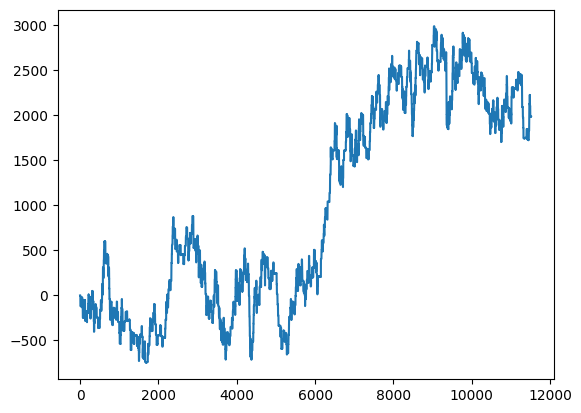

time: 73.4 ms (started: 2023-02-09 21:16:33 -05:00)


In [200]:
evenly_matched_games['balance'].plot()

In [198]:
evenly_matched_games.head(100)
#sum(evenly_matched_games['bet_won']==1)/len(evenly_matched_games)

,home_ml,away_ml,over,under,spread,home_spread,home_ps_odds,away_spread,away_ps_odds,movl,...,playoff_game,past_3_home_favorite_wins,past_3_away_favorite_wins,season,vig,home_win,bet_won,profit,bet_amount,balance
1,1.456783,2.830000,1.919388,1.913339,188.583333,-5.000000,1.914808,5.000000,1.917832,12.0,...,0.0,NaN,NaN,2014,1.039801,1,0.0,0.0,0.546448,-0.546448
5,2.841667,1.463867,1.941755,1.906751,197.500000,5.333333,1.945887,-5.333333,1.903131,13.0,...,0.0,NaN,NaN,2014,1.035028,1,1.0,1.0,0.542986,0.453552
6,1.265692,4.065000,1.923521,1.923521,189.750000,-8.000000,1.923550,8.000000,1.923550,6.0,...,0.0,NaN,NaN,2014,1.036084,1,0.0,0.0,0.326264,0.127288
8,1.839712,2.030000,1.915606,1.932438,187.500000,-1.333333,1.936900,1.333333,1.910999,-5.0,...,0.0,NaN,NaN,2014,1.036174,0,0.0,0.0,119.088436,-118.961148
9,2.381667,1.640594,1.917696,1.929807,194.000000,3.250000,1.922708,-3.250000,1.925733,4.0,...,0.0,NaN,NaN,2014,1.029409,1,1.0,1.0,0.723764,-117.961148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,3.106667,1.403395,1.920554,1.926603,207.666667,6.500000,1.916145,-6.500000,1.931272,6.0,...,0.0,0.000000,0.333333,2014,1.034446,1,1.0,1.0,0.474684,-54.093412
117,1.451278,2.890000,1.923521,1.923521,191.916667,-5.500000,1.909557,5.500000,1.938487,-6.0,...,0.0,0.333333,0.000000,2014,1.035068,0,1.0,1.0,0.529101,-53.093412
118,1.563279,2.580000,1.923521,1.923521,201.583333,-4.166667,1.930851,4.166667,1.917049,-4.0,...,0.0,0.666667,0.333333,2014,1.027278,0,1.0,1.0,0.632911,-52.093412
120,1.206731,4.942500,1.916306,1.931457,208.083333,-9.500000,1.926327,9.500000,1.921602,12.0,...,0.0,0.666667,0.000000,2014,1.031012,1,0.0,0.0,0.253646,-52.347058


time: 11.3 ms (started: 2023-02-09 21:15:33 -05:00)


In [102]:
evenly_matched_games.head()


6597

time: 2.18 ms (started: 2023-02-08 01:54:26 -05:00)


In [1]:
# ROI
cost = sum(evenly_matched_games['bet_amount'])
profit = sum(evenly_matched_games['profit'])
profit/cost

NameError: name 'evenly_matched_games' is not defined

profit over 9390 games: 9.651821805075432


<AxesSubplot: >

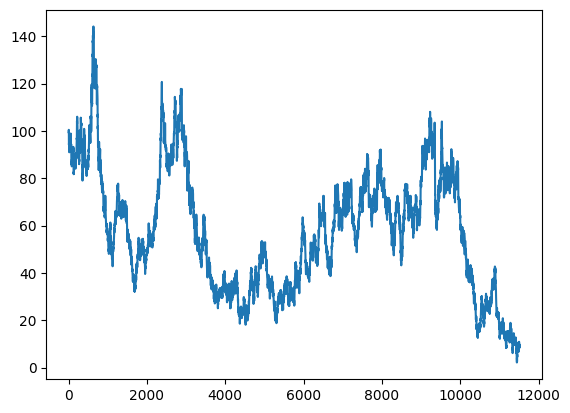

time: 1.1 s (started: 2023-02-08 18:31:26 -05:00)


In [283]:
print(f'profit over {len(evenly_matched_games)} games: {bet_mixed(evenly_matched_games)}')
evenly_matched_games['balance'].plot()

In [61]:
odds = [1.64]
interval = 0.85

for o in odds:
    massive_underdogs = df[ ((df.home_ml > o) & (df.home_ml < (o+interval))) | 
                           ((df.away_ml > o) & (df.away_ml < (o+interval))) ]
    print(f'number of underdogs with p(win) = {1/o}: {len(massive_underdogs)}')
    massive_underdog_winners = df[ (((df.h_win == 1) & (df.home_ml > df.away_ml)) |
                              ((df.h_win == 0) & (df.away_ml > df.home_ml))) &
                                  (((df.home_ml > o) & (df.home_ml < (o+interval))) | 
                                   ((df.away_ml > o) & (df.away_ml < (o+interval))))]
    print(f'number of underdog winners with p(win) = {1/o}: {len(massive_underdog_winners)}')
    print(f'win ratio {len(massive_underdog_winners)/len(massive_underdogs)}')

number of underdogs with p(win) = 0.6097560975609756: 3653
number of underdog winners with p(win) = 0.6097560975609756: 1628
win ratio 0.44566110046537094
time: 3.75 ms (started: 2023-02-07 19:27:53 -05:00)


In [119]:
print(f'profit over {len(df)} games: {profit(df)}')


profit over 11516 games: nan
time: 469 ms (started: 2023-02-08 02:01:07 -05:00)


In [112]:
df['away_ml'].describe()

count    11513.000000
mean         3.221325
std          2.638866
min          1.017506
25%          1.678534
50%          2.407778
75%          3.668889
max         36.333333
Name: away_ml, dtype: float64

time: 3.03 ms (started: 2023-02-08 01:58:36 -05:00)


## Team Consistency

In [ ]:
def get_past_wins_as_favorite(team_id, prev_matches, i):
    if len(prev_matches) < i: 
        return None
    prev_matches['res'] =  prev_matches.apply(lambda x:
                             1 if (x['home_id'] == team_id and x['favorite'] and x['favorite_won']) or 
                                      (x['away_id'] == team_id and not x['favorite'] and x['favorite_won'])        
                             else 0, axis=1)
    return prev_matches['res'].sum()/i    

In [ ]:
# favorite = 1: home team is favorite.
# favorite = 0: away team is favorite
match_df['favorite'] = match_df['home_ml'] < match_df['away_ml']
match_df['favorite_won'] = match_df.apply(lambda x: (x['favorite'] and x['h_win'] == 1) or
                                          (not x['favorite'] and x['h_win'] == 0), axis=1)
window_sizes = [2]

for w in tqdm(window_sizes):
    match_df[f'past_{w}_home_favorite_wins'] = match_df.apply(lambda x: 
                                    get_past_wins_as_favorite(x['home_id'], 
                                        get_prev_matches(x['date'], 
                                                         x['home_id'],
                                                         match_df
                                                        ).tail(w),
                                                    w), axis=1)
    match_df[f'past_{w}_away_favorite_wins'] = match_df.apply(lambda x: 
                                    get_past_wins_as_favorite(x['away_id'], 
                                        get_prev_matches(x['date'], 
                                                         x['away_id'],
                                                         match_df
                                                        ).tail(w),
                                                    w), axis=1)

In [ ]:
def get_recent_record(team_id, prev_matches, i):
    if len(prev_matches) < i:
        return None
    prev_matches['res'] = prev_matches.apply(lambda x:
                            1 if ((x['home_id'] == team_id and x['h_win']) or
                                  (x['away_id'] == team_id and not x['h_win']))
                            else 0, axis = 1)
    return matches['res'].sum()/i

## Determining High spread / high o/u

#### Spread distribution

<AxesSubplot: ylabel='Frequency'>

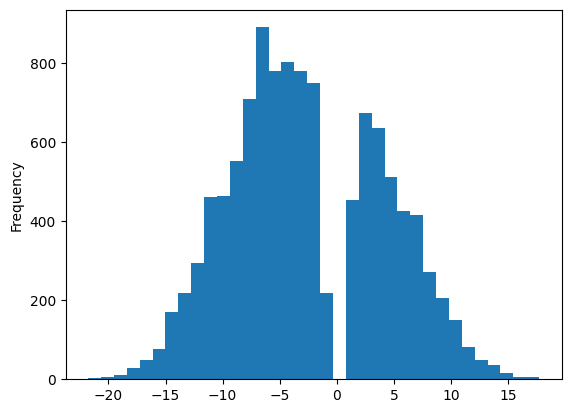

time: 78.9 ms (started: 2023-02-09 12:57:25 -05:00)


In [31]:
df[(df.home_spread >= 1) | (df.home_spread <= -1)]['home_spread'].plot.hist(bins=35)

In [40]:
print(df['home_spread'].mean())
print(df['home_spread'].median())


-2.5209003567586703
-3.5
time: 2.34 ms (started: 2023-02-09 12:59:21 -05:00)


#### O/U distribution

<AxesSubplot: ylabel='Frequency'>

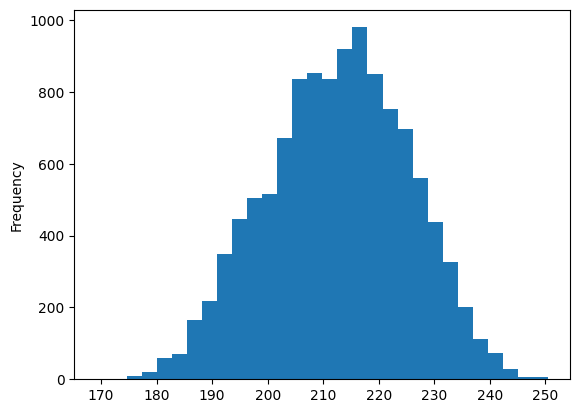

time: 86.1 ms (started: 2023-02-09 13:31:24 -05:00)


In [52]:
df['spread'].plot.hist(bins=30)

<AxesSubplot: ylabel='Frequency'>

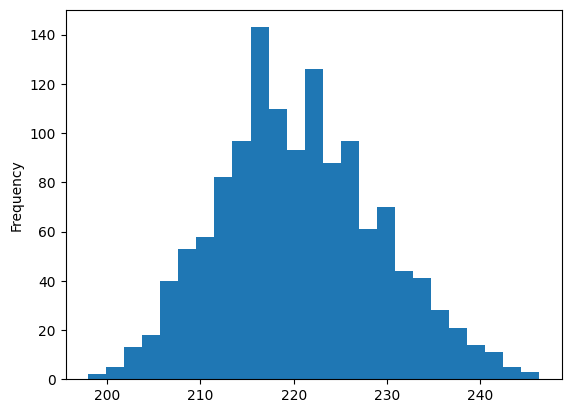

time: 80.2 ms (started: 2023-02-09 15:02:54 -05:00)


In [60]:
df[(df.season>2021)]['spread'].plot.hist(bins=25)

In [58]:
print(df['spread'].mean())
print(df['spread'].median())
for i in range(2017,2022):
    print(df[(df.season>i)]['spread'].mean())
    print(df[(df.season>i)]['spread'].median())
# we have to use previous seasons median spread

212.5932862719918
213.11111111111111
219.9095751204456
219.88888888888889
221.9366188536606
221.72222222222223
222.10787604391433
221.83333333333331
222.0887602878103
221.875
220.61858447156567
220.38888888888889
time: 8.64 ms (started: 2023-02-09 15:02:19 -05:00)


In [44]:
print(df['home_ml'].mean())
print(df['home_ml'].median())
print(df['away_ml'].mean())
print(df['away_ml'].median())
print(df['home_ps_odds'].mean())
print(df['home_ps_odds'].median())




2.0377396410893054
1.627538349893358
3.221325154613915
2.407777812745836
1.9194531275257436
1.9191711876127453
time: 4.23 ms (started: 2023-02-09 13:01:28 -05:00)


## Accuracy of Book Makers

In [63]:
df['ml_pred'] = df.apply(lambda x: 
    1 if x['home_ml'] < x['away_ml'] else 0, axis = 1)

df['ml_correct_pred'] = df.apply(lambda x: 
    1 if x['h_win'] == x['ml_pred'] else 0, axis = 1)

test = df[df.season >= 2020]

acc = test['ml_correct_pred'].sum()/len(test.index)
acc

0.6675831729447347

time: 89.6 ms (started: 2023-02-09 17:29:49 -05:00)


## Advanced Strategies

Predict probabilities using logistic regression
Use the difference in edge to make a kelly sized bet


In [159]:
test = df[df.season >= 2020]
lr_model = pickle.load(open('final_lr_model.sav', 'rb'))
df['home_win'] = df['movl'].map(lambda x: 0 if x < 0 else 1)
features = ['home_ml', 'spread', 'home_spread'] 
test_X = test[features]
predictions = lr_model.predict_proba(test_X)
predictions = [i[1] for i in predictions]

test['home_win'] = test['movl'].map(lambda x: 0 if x < 0 else 1)
test['lr_home_proba'] = predictions
test['home_implied'] = 1/test['home_ml']
test['away_implied'] = 1/test['away_ml']
test['lr_predict_home'] = test['lr_home_proba'].map(lambda x: 0 if x < 0.53 else 1)
test['correct_pred'] = test.apply(lambda x: 
    1 if x['home_win'] == x['lr_predict_home'] else 0, axis = 1)
acc = test['correct_pred'].sum()/len(test)
print(len(test))
print(f'Accuracy: {acc}')
test.head()


3637
Accuracy: 0.6681330767115755


,home_ml,away_ml,over,under,spread,home_spread,home_ps_odds,away_spread,away_ps_odds,movl,...,past_3_home_favorite_wins,past_3_away_favorite_wins,season,vig,home_win,lr_home_proba,home_implied,away_implied,lr_predict_home,correct_pred
7879,2.493333,1.589445,1.919855,1.920983,224.055556,3.666667,1.941213,-3.666667,1.901385,10.0,...,0.000000,0.0,2020,1.030220,1,0.375355,0.401070,0.629151,0,0
7880,1.354878,3.374444,1.918227,1.922269,229.222222,-6.722222,1.926456,6.722222,1.913742,8.0,...,0.333333,0.0,2020,1.034419,1,0.724830,0.738074,0.296345,1,1
7881,2.424444,1.617489,1.910436,1.929373,216.666667,3.555556,1.932851,-3.555556,1.909180,1.0,...,0.333333,0.0,2020,1.030708,1,0.378909,0.412466,0.618242,0,0
7882,1.166249,5.548889,1.916263,1.923449,214.444444,-10.666667,1.919005,10.666667,1.921910,9.0,...,0.333333,0.0,2020,1.037666,1,0.820518,0.857450,0.180216,1,1
7883,1.329089,3.531111,1.926941,1.912815,211.111111,-7.333333,1.934068,7.333333,1.906462,-9.0,...,0.000000,0.0,2020,1.035592,0,0.740728,0.752395,0.283197,1,0


time: 87.3 ms (started: 2023-02-09 18:59:35 -05:00)


### Strategy 1: Bet using Kelly criterion and LR proba

In [164]:
def bet_kelly(df1):
    starting_balance = 100
    balance = starting_balance
    kelly_frac = 1/8
    i = 0
    for index, row in df1.iterrows():
        # if i == 50:
        #     break
        # i += 1
        underdog = False
        bet_won = 0
        profit = 0
        bet_amount = 0
                

        if row['lr_predict_home']:
            kelly_prob = row['lr_home_proba']
            bet_amount = kelly_size(kelly_prob,row['home_ml']-1, kelly_frac) *balance

            if row['home_win']:
                profit = bet_amount * (row['home_ml']-1)
                bet_won = 1
                balance += profit + bet_amount
        else:
            kelly_prob = 1-row['lr_home_proba']
            bet_amount =kelly_size(kelly_prob,row['away_ml']-1, kelly_frac)*balance

            if not row['home_win']:
                profit = bet_amount * (row['away_ml']-1)
                bet_won = 1
                balance += profit + bet_amount

        balance -= bet_amount
        df1.at[index, 'profit'] = profit
        df1.at[index, 'bet_won'] = bet_won
        df1.at[index, 'bet_amount'] = bet_amount
        df1.at[index, 'balance'] = balance
    return balance - starting_balance

time: 748 µs (started: 2023-02-09 20:13:51 -05:00)


In [136]:
def kelly_size(p, b, frac):
    bet_size = (p - (1-p)/b)*frac
    if bet_size <= 0:
        bet_size = 0.01
    return bet_size

time: 273 µs (started: 2023-02-09 18:46:58 -05:00)


profit over 3637 games: -62.84530515689984
win ratio:  {0.6681330767115755}


<AxesSubplot: >

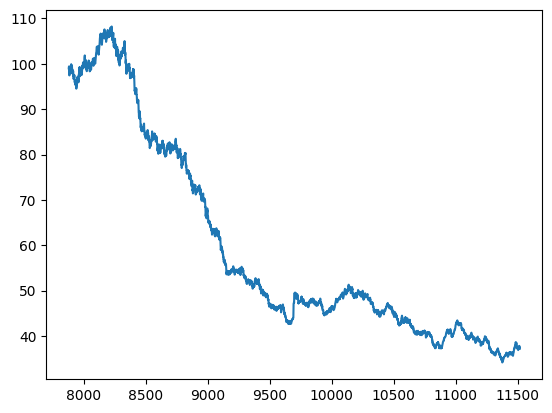

time: 458 ms (started: 2023-02-09 20:13:54 -05:00)


In [165]:
print(f'profit over {len(test)} games: {bet_kelly(test)}')
print(f'win ratio: ',{sum(test['bet_won'])/len(test)})
test['balance'].plot()


In [135]:
test.head()

,home_ml,away_ml,over,under,spread,home_spread,home_ps_odds,away_spread,away_ps_odds,movl,...,home_win,lr_home_proba,home_implied,away_implied,lr_predict_home,correct_pred,profit,bet_won,bet_amount,balance
7879,2.493333,1.589445,1.919855,1.920983,224.055556,3.666667,1.941213,-3.666667,1.901385,10.0,...,1,0.375355,0.401070,0.629151,0,0,9.290795,1.0,6.221515,109.290795
7880,1.354878,3.374444,1.918227,1.922269,229.222222,-6.722222,1.926456,6.722222,1.913742,8.0,...,1,0.724830,0.738074,0.296345,1,1,0.387849,1.0,1.092908,109.678644
7881,2.424444,1.617489,1.910436,1.929373,216.666667,3.555556,1.932851,-3.555556,1.909180,1.0,...,1,0.378909,0.412466,0.618242,0,0,9.245919,1.0,6.490895,118.924563
7882,1.166249,5.548889,1.916263,1.923449,214.444444,-10.666667,1.919005,10.666667,1.921910,9.0,...,1,0.820518,0.857450,0.180216,1,1,0.197711,1.0,1.189246,119.122274
7883,1.329089,3.531111,1.926941,1.912815,211.111111,-7.333333,1.934068,7.333333,1.906462,-9.0,...,0,0.740728,0.752395,0.283197,1,0,0.000000,0.0,1.191223,117.931051


time: 11 ms (started: 2023-02-09 18:46:00 -05:00)


## Strategy 2: Bet based on spread, o/u, odds difference

In [203]:
def bet_strategy2(df):
    balance = 0
    
    ou_3q = defaultdict(float)
    spread_3q = defaultdict(float)
    
    for i in range(2020, 2022):
        ou_3q[i] = df[(df.season == i)]['spread'].quantile(0.7)
        spread_3q[i] = df[(df.season==i)]['home_spread'].quantile(0.7)
    
    
    for index, row in df.iterrows():
        underdog = False
        bet_won = 0
        profit = 0
        factor = max(1, balance * 0.05)
        if row['spread'] > ou_3q[row['season']] and \
            abs(row['home_spread']) < 6:
            # bet underdog
            underdog = True
        
        if (row['home_ml'] > row['away_ml'] and underdog) or \
            (row['home_ml'] < row['away_ml'] and not underdog):
            bet_amount = 1/(row['home_ml']-1)
            # if not underdog:
            #     bet_amount = 1
            if row['h_win']:
                profit = bet_amount * (row['home_ml']-1) 
                bet_won = 1
                balance += profit + bet_amount
        else:
            bet_amount = 1/(row['away_ml']-1)
            # if not underdog:
            #     bet_amount = 1
            if not row['h_win']:
                profit = bet_amount * (row['away_ml']-1)
                bet_won = 1
                balance += profit + bet_amount
        
        balance -= bet_amount
        df.at[index, 'profit'] = profit
        df.at[index, 'bet_won'] = bet_won
        df.at[index, 'bet_amount'] = bet_amount
        df.at[index, 'balance'] = balance
    return balance

time: 942 µs (started: 2023-02-09 21:18:35 -05:00)


profit over 3637 games: -473.1783526823906
win ratio:  {0.6156172669782788}


<AxesSubplot: >

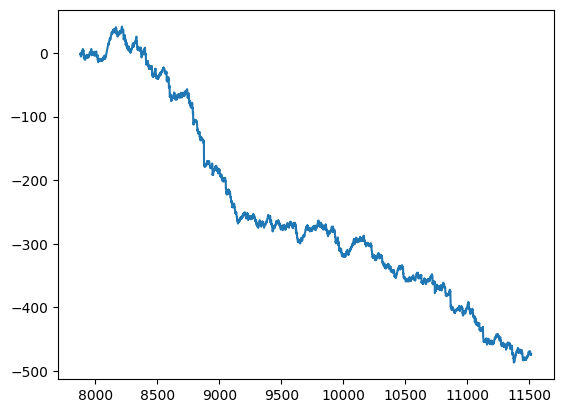

time: 462 ms (started: 2023-02-09 21:18:35 -05:00)


In [204]:
print(f'profit over {len(test)} games: {bet_strategy2(test)}')
print(f'win ratio: ',{sum(test['bet_won'])/len(test)})
test['balance'].plot()

In [170]:
from collections import defaultdict
ou_3q = defaultdict(float)
for i in range(2020, 2022):
        ou_3q[i] = df[(df.season == i)]['spread'].quantile(0.7)

time: 4.07 ms (started: 2023-02-09 21:00:55 -05:00)


In [172]:
df[(df.season==2022)]['home_spread'].quantile(0.3)

-6.444444444444445

time: 2.73 ms (started: 2023-02-09 21:04:20 -05:00)
